<h1 style="color:cyan;">Anomaly Detection in Time Series Data using Autoencoders</h1>

Autoencoders are unsupervised learning models that are capable of learning efficient representations of input data.
They consist of an encoder network that maps the input data to a lower-dimensional latent space and a decoder network that reconstructs the input data from the latent space.

The idea is to train an autoencoder on normal time series data to be used as refrence when trying to reconstruct and measure the error

We'll start with the following:
- Load time series data from Yahoo finanace using the yfinance package
- preprocess the data
- build and train an autoencoder model
- use the model to detect anomalies

<h3 style="color:#00BFFF;">Download the data</h3>

In [28]:
#! pip install yfinance
#! pip install pandas
#! pip install tensorflow
#! pip install numpy
#! pip install matplotlib
#! pip install statsmodels

You should consider upgrading via the 'g:\my drive\ds\anomaly detection using autoencoders\autoencoders_env\scripts\python.exe -m pip install --upgrade pip' command.


In [338]:
# import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [83]:
def split_data(data, split_ratio):
    """Split time series data into train and test sets."""
    train_size = int(len(data) * split_ratio)
    train_data = data.iloc[:train_size, :]
    test_data = data.iloc[train_size:, :]
    return train_data, test_data

let’s consider the following assets: JPM (JPMorgan Chase & Co.), GS (Goldman Sachs Group Inc.), MS (Morgan Stanley), BLK (BlackRock Inc.) and C (Citigroup Inc.). We will download the data for the period until the end of November 2023.

In [84]:
assets = ['JPM', 'GS', 'MS', 'BLK', 'C', 'HPI']
start_date = '2018-01-01'
end_date = '2023-11-30'

data = yf.download(assets, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  6 of 6 completed


In [85]:
data.head()

Ticker,BLK,C,GS,HPI,JPM,MS
Date,,,,,,
2018-01-02,432.673767,59.538162,222.359329,12.768817,89.602821,42.931221
2018-01-03,437.238831,59.722336,220.289368,12.762847,89.694145,43.046375
2018-01-04,443.010986,60.458961,223.368179,12.804613,90.979080,43.704453
2018-01-05,446.785339,60.378883,222.228882,12.822512,90.395012,43.688007
2018-01-08,450.117798,59.674278,219.002213,12.858315,90.528519,43.507023


<h3 style="color:#00BFFF;">Data Preprocessing</h3>

The preprocessing steps include handling missing values, normalizing the data and splitting it into training and testing sets.

In [86]:
# Handling missing values - using forawrd filling (because these are stock prices)
data = data.ffill()

In forward filling, the last known observation is carried forward to fill in the missing value. This means that the missing value is replaced with the value from the last non-missing observation.

### lets normalize the data

In [87]:
# Lets normalize the data using min-max scaling (values between 0 to 1)
data_normalized = (data - data.min()) / (data.max() - data.min())


In [88]:
# Split the data into train and test
split_ratio = 0.8
train_data, test_data = split_data(data = data_normalized, split_ratio =split_ratio)
print(f"train shape: {train_data.shape} \n")
print(f"test shape: {test_data.shape} \n")

train shape: (1190, 6) 

test shape: (298, 6) 



<h3 style="color:#00BFFF;">Building the Autoencoder Model</h3>

We will use the Keras library, which provides a high-level API for building neural networks.

![Autoencoder](autoencoders.png)

An autoencoder (AE) is a type of artificial neural network (ANN) used to learn data pattern. It tries to predict it's own input! 
A typical AE has two parts: an encoder and a decoder.

<b>The Encoder:</b> The encoder encodes/compresses an input into latent space variables just like any other ANN.

<b>The Decoder:</b> The decoder decodes/reconstructs the input from the latent variables</p>

<b>The latent variables,</b> which represent encoded data in the latent space, are the outputs of the activation functions in the “bottleneck” layer





##### What is the use for an AE to predict its own input?

The AE learns an approximation to the identity function. The predicted output is similar to the input. By placing constraints on the network, i.e., limiting the number of hidden units, we can discover interesting structure about the data (Ng, 2011).

In an unsupervised learning setting, we don’t know the target labels of a dataset, but we do know there are a small number of outliers/anomalies in the dataset. A well-trained AE learns regularities. Hence, the AE will predict low reconstruction errors for normal examples and high errors for anomalous examples (Agmon, 2020).

<h3 style="color:#FFDEAD;">Time to Code...</h3>

We will use the Keras library, which provides a high-level API for building neural networks.<br>
Let’s import the necessary libraries and define the architecture of our autoencoder model:

The encoder network consists of three dense layers with decreasing dimension.
<div class="alert alert-info">
  <strong>Do you remember what a dense layer is?</strong> 
  
  - In a dense layer, each neuron receives input from every neuron in the previous layer.<br> 
  - Each connection between neurons in the previous layer and neurons in the dense layer has an associated weight (These weights determine the strength of the connection and are adjusted during the training process ).<br>
  - Each neuron in the dense layer applies an activation function to the weighted sum of its inputs plus its bias.
</div>


The decoder network mirrors the encoder network. The input and output dimensions of the autoencoder are the same, as we aim to reconstruct the input data.
- We'll be using ReLU (Rectified Linear Unit) as activation function for the dense layers, mostly because it's more efficient and general use. 
- We'll use Sigmoid for the output layer, mostly because its nature of providing probability for classes between 0 to 1.


In [21]:
# Building the Autoencoder Model
try:
    # will fail on a single time series 
    input_dim = train_data.shape[1]
except:
    input_dim = 1

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
encoder_output = Dense(16, activation='relu')(encoder)


<h5 style="color:orange;">Just as a reminder...</h5>

- An input layer is created with a shape that matches the input dimension (input_dim).
- The encoder part of the autoencoder consists of three dense (fully connected) layers:
- The first layer has 64 neurons with ReLU activation.
- The second layer has 32 neurons with ReLU activation.
- The third layer, which is the encoder's output layer, has 16 neurons with ReLU activation.

In [ ]:

# Decoder
decoder = Dense(32, activation='relu')(encoder_output)
decoder = Dense(64, activation='relu')(decoder)
decoder_output = Dense(input_dim, activation='sigmoid')(decoder)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

<h5 style="color:orange;">Adam optimizer?!?! Just as a reminder...</h5>An optimizer is an algorithm or method used to change the attributes of the neural network such as weights and learning rate to reduce the losses. It helps in finding the best set of weights for the model to minimize the loss function. 
Specifically, Adam combines the advantages of two other extensions of stochastic gradient descent. It computes adaptive learning rates for each parameter.
<br>
<h5 style="color:orange;">and the loss func... mse... mmmmm ?!?!</h5>
The Mean Squared Error (MSE) loss function quantifies the difference between the original input and its reconstruction, guiding the optimizer on how to adjust the weights to improve the model's performance.



<h3 style="color:#FFDEAD;">Training the Autoencoder Model</h3>
Now that our autoencoder model is defined, we can train it using the training data. During training, the model learns to reconstruct the input data with minimal loss.<br>
We will train the model for 100 epochs with a batch size of 32.

In [22]:
epochs = 100
batch_size = 32

autoencoder.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0663
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0440
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0098
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0023
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0021
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0017
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.0014
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0013
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.0012
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.00

Once the training is complete, our autoencoder model is ready to detect anomalies in financial time series data.

<h3 style="color:#FFDEAD;">Detecting Anomalies</h3>

To detect anomalies, we will use the reconstruction error of the autoencoder. <br>
To detect anomalies in time series data, the trained autoencoder can be used to reconstruct new data points. If the difference between the original data point and its reconstructed version is above a certain threshold, the data point is considered anomalous.<br>
The reconstruction error measures the difference between the input data and its reconstructed output. Anomalies are characterized by higher reconstruction errors.<br><br>

We'll be measuring the mean-squared error:

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Text(0.5, 1.0, 'Anomaly Detection')

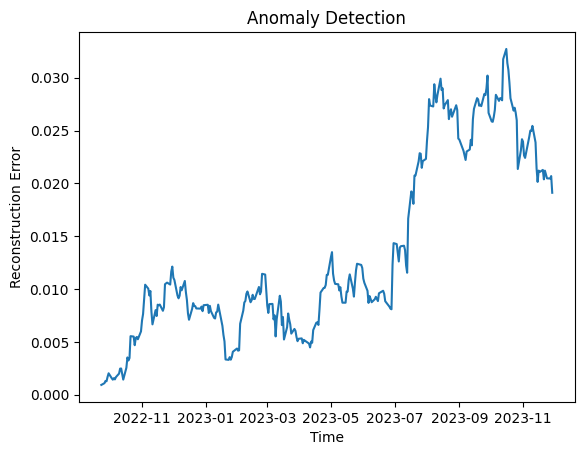

In [23]:
reconstructed_data = autoencoder.predict(test_data)
reconstruction_errors = np.mean(np.square(test_data - reconstructed_data), axis=1)


plt.plot(reconstruction_errors)
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Detection')



we can observe that the reconstruction errors are relatively low for most of the time series data.<br> 
However, there are certain points where the reconstruction errors spike, indicating the presence of anomalies.

From this point there are planty of classical ways to point on the possible anomalies. approaches like IQR, or 3 standard deviations, etc.

To set a threshold for anomaly detection, we can calculate the mean and standard deviation of the reconstruction errors and consider any data point with a reconstruction error greater than the mean plus three times the standard deviation as an anomaly.

C:\Users\cohenniv\AppData\Local\Temp\ipykernel_49100\1520617350.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anomalies = reconstruction_errors[anomalies]


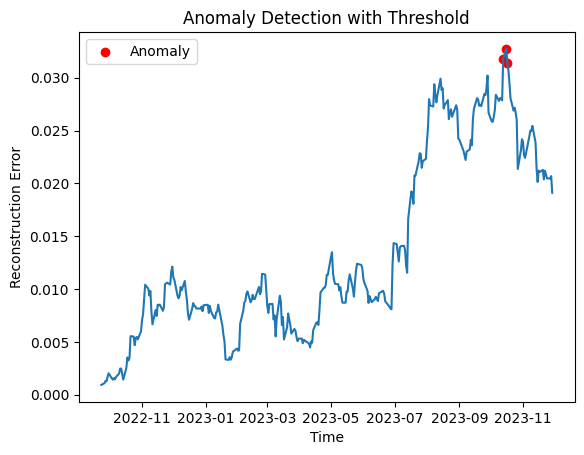

In [24]:
threshold = np.mean(reconstruction_errors) + 2* np.std(reconstruction_errors)
anomalies = np.where(reconstruction_errors >= threshold)[0]
anomalies = reconstruction_errors[anomalies]

plt.plot(reconstruction_errors)
plt.scatter(anomalies.index, anomalies, color='red', label='Anomaly')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Detection with Threshold')
plt.legend()

Lets pointout the anomalies values:

In [25]:
data.describe()

Ticker,BLK,C,GS,HPI,JPM,MS
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000
mean,571.555468,52.050249,257.972158,14.567437,114.744099,60.994435
std,153.800030,8.713544,72.591662,1.424425,23.049561,21.551831
min,296.284332,29.984591,122.197929,7.061186,69.640213,24.220282
25%,432.668808,44.425790,189.726398,13.648655,93.467091,40.552412
50%,575.292633,52.985233,235.058739,14.476536,111.265099,57.321442
75%,682.269089,58.949791,322.954453,15.665613,137.195015,81.411940
max,908.263184,71.015617,395.365997,17.479021,159.780838,99.910072


In [26]:
anomalies_df = data.loc[data.index.isin(anomalies.index),:]
anomalies_df.describe()

Ticker,BLK,C,GS,HPI,JPM,MS
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,624.995158,39.933976,306.312866,12.867478,146.035736,76.532878
std,4.636538,0.232730,2.877371,0.057825,0.237219,1.244897
min,619.654175,39.698082,304.622162,12.804385,145.775528,75.408386
25%,623.499512,39.819262,304.651703,12.842241,145.933632,75.864002
50%,627.344849,39.940441,304.681244,12.880096,146.091736,76.319618
75%,627.665649,40.051924,307.158218,12.899024,146.165840,77.095123
max,627.986450,40.163406,309.635193,12.917952,146.239944,77.870628



<h2 style="color:cyan;">It's time to take it to the next level now!</h2>

## Time for LSTM!  
#### LSTWhaaatt !?
(we'll get to that soon)

In [210]:
# Define constants
DATA_FILEPATH = 'power_consumption.txt'
TRAIN_SIZE = 800
EXT_LSTM_UNITS = 64
INT_LSTM_UNITS = 32

Let us define methods and moke the code more modularize this time using the power consumption dataset from Kaggle

In [ ]:
def load_data(filepath):
    """Load and clean the time series data from file."""
    project_data = pd.read_csv(filepath, delimiter=";")
    project_data['timestamp'] = pd.to_datetime(project_data['Date']+' '+project_data['Time'])
    project_data['Global_active_power'] = pd.to_numeric(project_data['Global_active_power'], errors='coerce')
    project_data = project_data[["timestamp", "Global_active_power"]]
    project_data.fillna(value=project_data['Global_active_power'].mean(), inplace=True)
    project_data.isna().sum()
    project_data.set_index('timestamp',inplace=True)
    return project_data

: 

In [212]:
#load the data from the file
df = load_data(DATA_FILEPATH)
df.head()


C:\Users\cohenniv\AppData\Local\Temp\ipykernel_49100\284334225.py:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  project_data = pd.read_csv(filepath, delimiter=";")
C:\Users\cohenniv\AppData\Local\Temp\ipykernel_49100\284334225.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  project_data['timestamp'] = pd.to_datetime(project_data['Date']+' '+project_data['Time'])


,Global_active_power
timestamp,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


##### Visualize the data

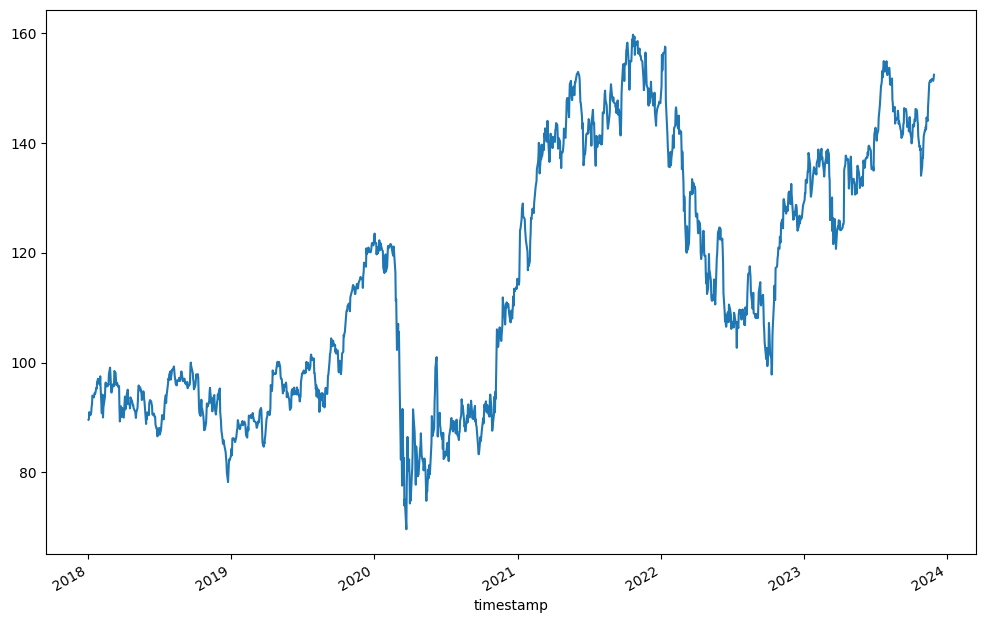

In [262]:
fig, ax = plt.subplots()
df.plot(legend=False, ax=ax)
plt.show()

In [213]:
# Lets normalize the data
df_normalized = (df - df.min()) / (df.max() - df.min())


In [214]:
#split the data between train and test set
train_data, test_data = split_data(data = df_normalized, split_ratio =split_ratio)
print(f"train shape: {train_data.shape} \n")
print(f"test shape: {test_data.shape} \n")

train shape: (1660207, 1) 

test shape: (415052, 1) 



This is a large series, lets try to work with a smaller training sample:

In [215]:
train_data = df_normalized.iloc[:TRAIN_SIZE, :]
test_data = df_normalized.iloc[TRAIN_SIZE:, :]
print(f"train shape: {train_data.shape} \n")
print(f"test shape: {test_data.shape} \n")

train shape: (800, 1) 

test shape: (2074459, 1) 



#### Building the Autoencoder Model
With the preprocessed data in hand, we can now proceed to build our autoencoder model. 

In [216]:
def build_model_v2(input_shape, ext_lstm_units, int_lstm_units):
    """Build LSTM Autoencoder model."""
    input_layer = Input(shape=input_shape)
    encoder = LSTM(ext_lstm_units, activation='relu', return_sequences=True)(input_layer)
    encoder_1 = LSTM(int_lstm_units, activation='relu')(encoder)
    repeat = RepeatVector(input_shape[0])(encoder_1)
    decoder = LSTM(int_lstm_units, activation='relu', return_sequences=True)(repeat)
    decoder_1 = LSTM(ext_lstm_units, activation='relu', return_sequences=True)(decoder)
    output_layer = TimeDistributed(Dense(input_shape[1]))(decoder_1)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

<h5 style="color:orange;">Hold it! lets explain...</h5>

The encoder consists of two LSTM (Long Short-Term Memory) layers:
- The first LSTM layer has ext_lstm_units units, uses ReLU activation, and returns the full sequence of outputs for each time step (return_sequences=True).
- The second LSTM layer has int_lstm_units units, uses ReLU activation, and returns only the last output in the sequence, which effectively captures the encoded representation of the input sequence.

- The RepeatVector layer repeats the encoded representation (the output of the second LSTM layer) for as many times as there are time steps 

- The decoder consists of two LSTM layers, mirroring the structure of the encoder but in reverse

- The TimeDistributed layer applies a dense layer to each time step independently. This dense layer has a number of units equal to the number of features per time step 


<div class="alert alert-info">
  <strong>A note...</strong> 
  
Using different numbers of units in internal and external LSTM layers allows the model to capture and process different levels of abstraction in the time series data.
ext_lstm_units helps in capturing immediate temporal dependencies, while int_lstm_units helps in capturing more complex patterns and dependencies within the sequence.
</div>



In [217]:
# Build model
INPUT_SHAPE = (train_data.shape[1], 1)

# model = build_model(INPUT_SHAPE, LSTM_UNITS)
model = build_model_v2(INPUT_SHAPE, EXT_LSTM_UNITS, INT_LSTM_UNITS)

In [231]:
history = model.fit(train_data, train_data, epochs=12, batch_size=100, validation_split=0.2)

Let's plot training and validation loss to see how the training went.

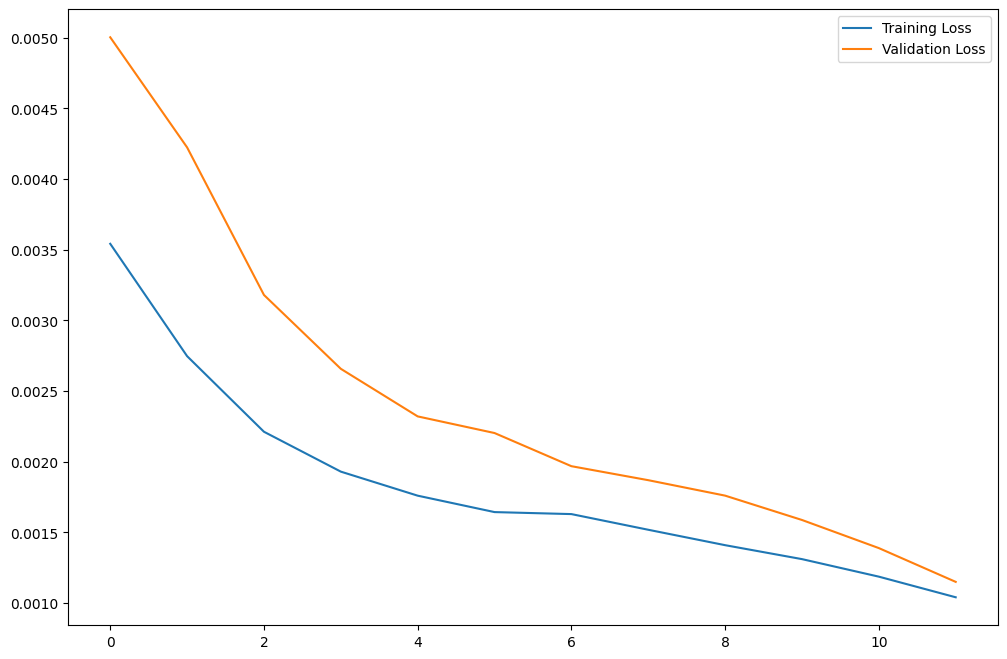

In [233]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

##### We will detect anomalies by determining how well our model can reconstruct the input data.

- Find Mean Squared Error (MSE) loss on training samples.
- Find max MSE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
- If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

In [234]:
# Get train MSE loss.
train_pred = model.predict(train_data)
train_mse_loss =  np.mean(np.power(train_data - train_pred.reshape(len(train_data),1), 2), axis=1)

# Get reconstruction loss threshold.
threshold = np.max(train_mse_loss)
print("Reconstruction error threshold: ", threshold)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Reconstruction error threshold:  0.07387727969550527


MSE is highly sensitive to outliers because it squares the errors, which gives larger errors disproportionately more weight. This can be useful if you want to penalize larger errors more severely.

Before moving to the test set lets compare the reconstruction
Just for fun, let's see how our model has recontructed the first sample

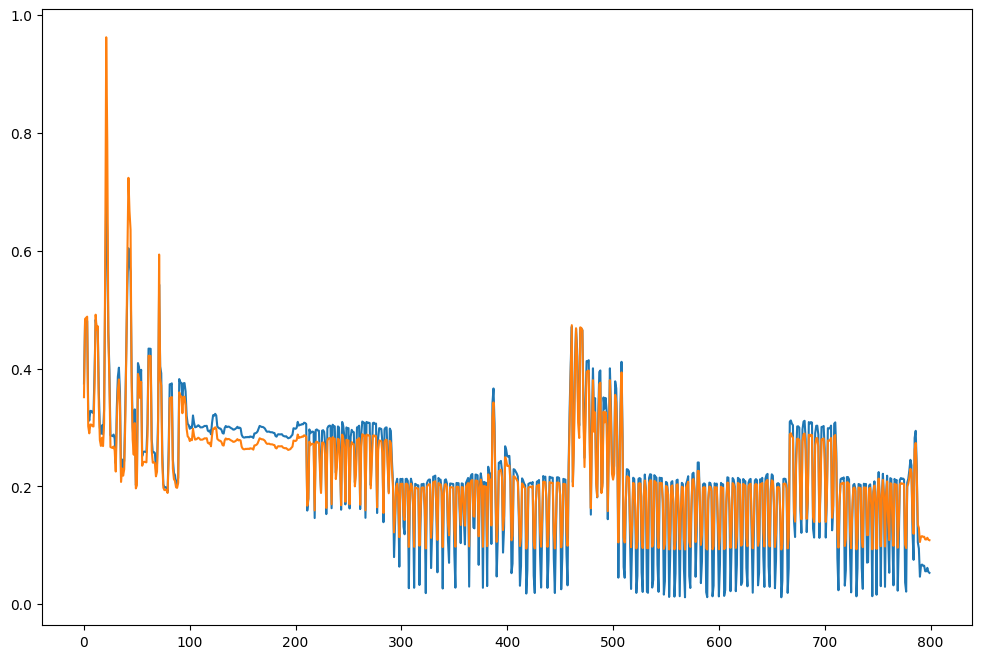

In [235]:
# Checking how the first sequence is learnt
plt.plot(train_data.to_numpy().reshape(len(train_data),1))
plt.plot(train_pred.reshape(len(train_data),1))
plt.show()

Lets try and predict on the test set

In [236]:
test_predictions  = model.predict(test_data)

64827/64827 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step


#### Now will calculate the reconstruct error


In [237]:
def calculate_error(test_data, predictions):
    """Calculate mean squared error between test data and predictions."""
    print("test_data shape", test_data.shape)
    print("predictions shape", predictions.shape)
    mse = np.mean(np.power(test_data - predictions, 2), axis=1)
    return mse

In [238]:
# Calculate reconstruction error for each time step
mse = calculate_error(test_data, test_predictions.reshape(len(test_data),1))
print("Mean Square Error = ", mse)

test_data shape (2074459, 1)
predictions shape (2074459, 1)
Mean Square Error =  timestamp
2006-12-17 06:44:00    0.003194
2006-12-17 06:45:00    0.003098
2006-12-17 06:46:00    0.003226
2006-12-17 06:47:00    0.003098
2006-12-17 06:48:00    0.003216
                         ...   
2010-11-26 20:58:00    0.001808
2010-11-26 20:59:00    0.001815
2010-11-26 21:00:00    0.001838
2010-11-26 21:01:00    0.001853
2010-11-26 21:02:00    0.001861
Length: 2074459, dtype: float64


##### Time for anomalies detection!

In [239]:
def detect_anomalies(mse, threshold=None):
    """Detect anomalies in test data using thresholding."""
    if threshold==None:
        threshold = np.mean(mse) + 3*np.std(mse)
    else:
        threshold
    print("Threshold = ", np.round(threshold, 2))
    anomalies = np.where(mse > np.round(threshold, 2))[0]
    return anomalies


def plot_results(test_data, anomalies):
    """Plot test data with detected anomalies."""
    plt.figure(figsize=(14, 10))
    # Create subplot grid with 2 rows and 1 column
    plt.subplot(2, 1, 1)
    plt.plot(test_data)
    plt.title('Power consumption')
    plt.xlabel('Date')
    plt.ylabel('Consumption')
    plt.grid()

     # Create a new subplot for the anomaly plot
    plt.subplot(2, 1, 2)
    plt.plot(test_data['Global_active_power'].iloc[anomalies], 'ro')
    plt.title('Power consumption Anomaly Detection')
    plt.xlabel('Date')
    plt.ylabel('Consumption ')
    plt.grid() 
    plt.show()

Threshold =  0.07


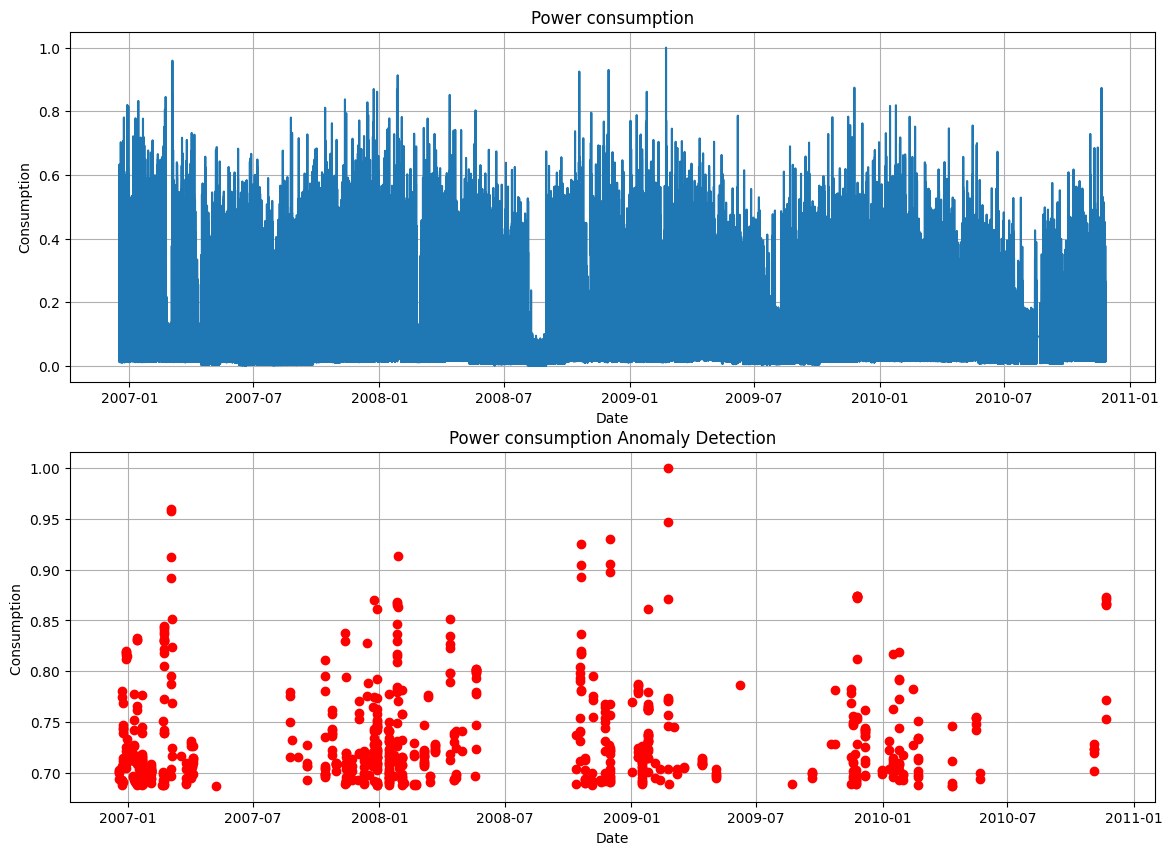

In [240]:
# Detect anomalies in test data
anomalies = detect_anomalies(mse, threshold = threshold)

# Plot test data with anomalies
plot_results(test_data, anomalies)

One of the main advantages of using autoencoders for time series anomaly detection is that they can be trained on large amounts of data without requiring manual feature engineering. This makes them particularly useful for analyzing complex time series data with multiple variables or high dimensionality.

### Lets go back to our financial data
This time we'll add a new component - <b>TIME STEPS</b>

#### Time steps
In time series analysis, "time steps" refers to the number of previous observations used to predict the next observation or reconstruct the current one. Creating sequences of time steps is essential when using models like LSTM (Long Short-Term Memory) networks because they are designed to learn temporal dependencies from sequences of data.

For example, the price of a stock today is influenced by its prices over the past few days. Creating sequences allows the model to learn these dependencies.

In the provided code, the function create_sequences takes the entire dataset and the number of time_steps as input, and it returns an array of sequences:

[*********************100%%**********************]  1 of 1 completed


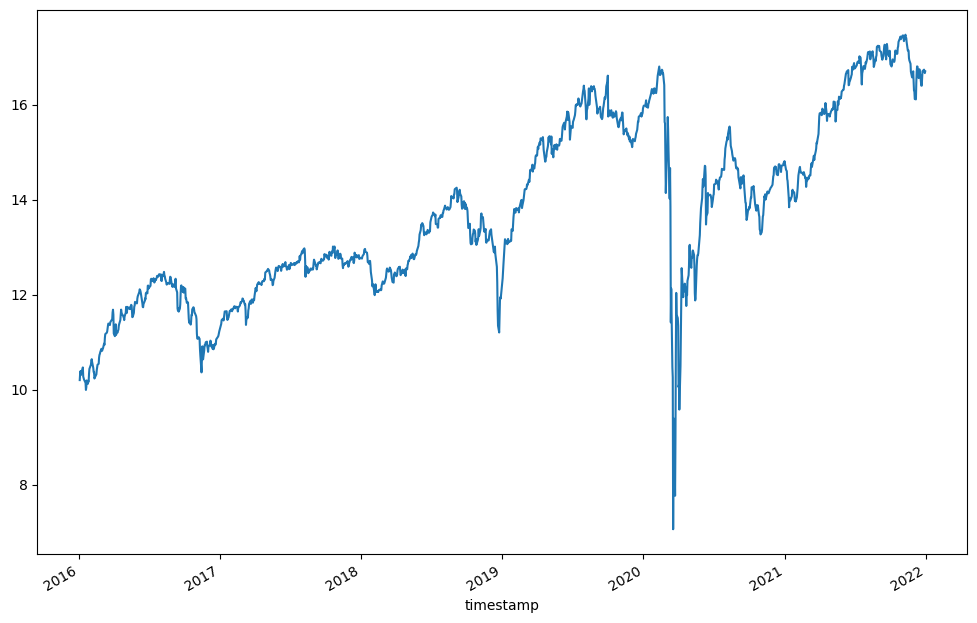

In [442]:
assets = ['HPI']
start_date = '2016-01-01'
end_date = '2021-12-31'

df = yf.download(assets, start=start_date, end=end_date)
df.reset_index(drop=False, inplace=True)
df['timestamp'] = pd.to_datetime(df['Date'])
df['Adj_Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
df = df[["timestamp", "Adj_Close"]]
df.set_index('timestamp',inplace=True)
df = df.ffill()
df.head()

fig, ax = plt.subplots()
df.plot(legend=False, ax=ax)
plt.show()

Data was loaded, now execute the complete process we just build...

train shape: (981, 1) 



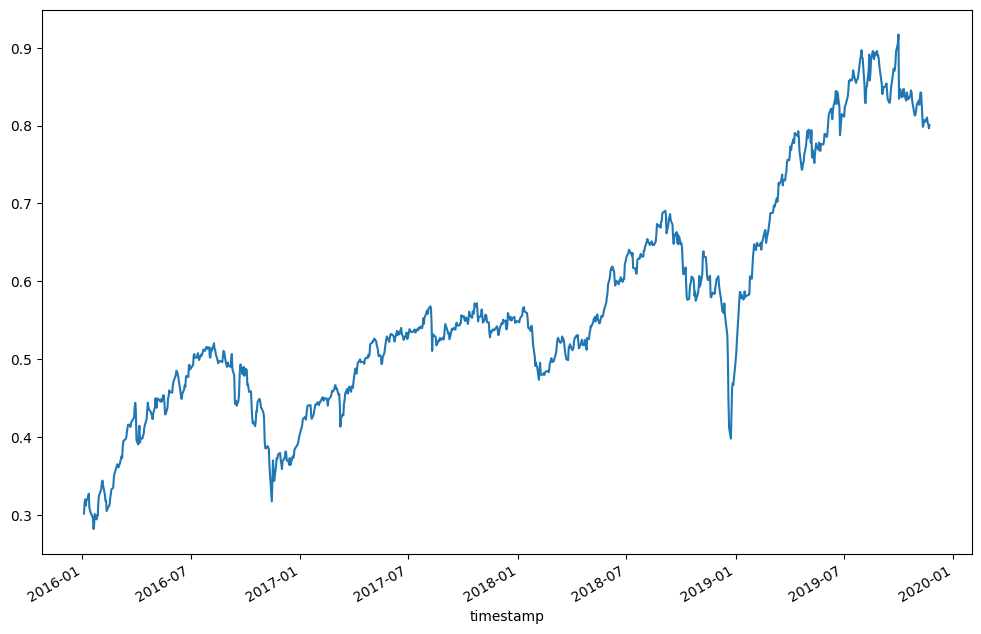

In [443]:
# Lets normalize the data
df_normalized = (df - df.min()) / (df.max() - df.min())

#split the data between train and test set
train_data, test_data = split_data(data = df_normalized, split_ratio =0.65)
print(f"train shape: {train_data.shape} \n")
fig, ax = plt.subplots()
train_data.plot(legend=False, ax=ax)
plt.show()


test shape: (529, 1) 



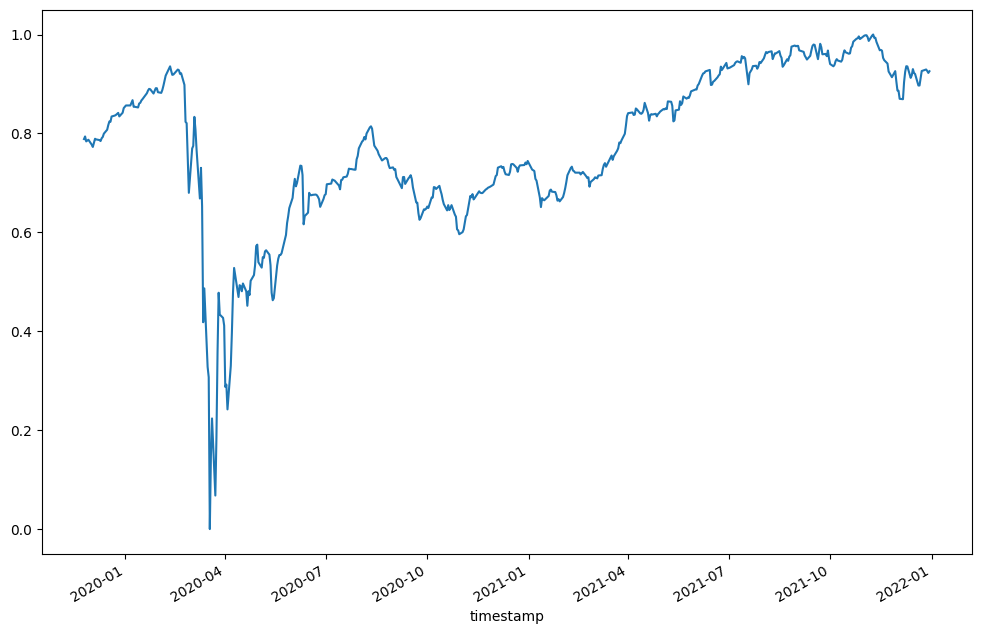

In [444]:
print(f"test shape: {test_data.shape} \n")
fig, ax = plt.subplots()
test_data.plot(legend=False, ax=ax)
plt.show()



Create Sequences:<br>
Create sequences combining TIME_STEPS contiguous data values from the training data.<br>

In [445]:
TIME_STEPS = 7

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(train_data.values, time_steps=TIME_STEPS)
print("Training input shape: ", x_train.shape)

Training input shape:  (975, 7, 1)


In [446]:

# Build model
INPUT_SHAPE = (x_train.shape[1], 1)

# model = build_model(INPUT_SHAPE, LSTM_UNITS)
model = build_model_v2(INPUT_SHAPE, EXT_LSTM_UNITS, INT_LSTM_UNITS)

# Train model
history = model.fit(
    x_train, 
    x_train, 
    epochs=50, 
    batch_size=30,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.2315 - val_loss: 0.2314
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0724 - val_loss: 0.1720
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0520 - val_loss: 0.1275
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0299 - val_loss: 0.0842
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - val_loss: 0.1113
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 0.0351
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7823e-04 - val_loss: 0.0657
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6576e-04 - val_loss: 0.0519
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5007e-04 - val_loss: 0.0388
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5826e-04 - val_loss: 0.0330
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3587e-04 - val_loss: 0.0233
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - 

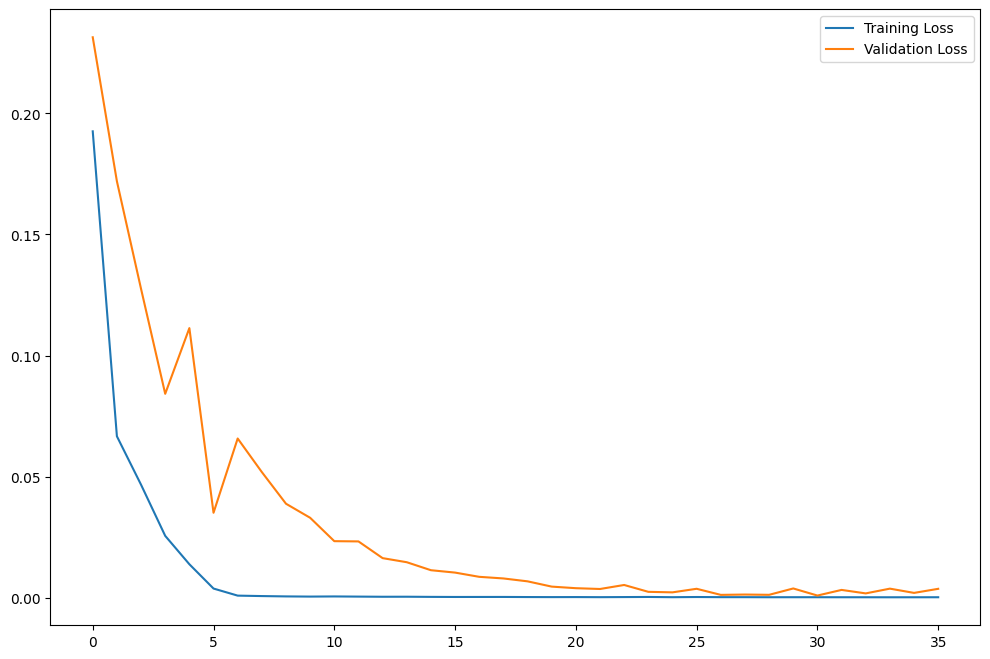

In [447]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


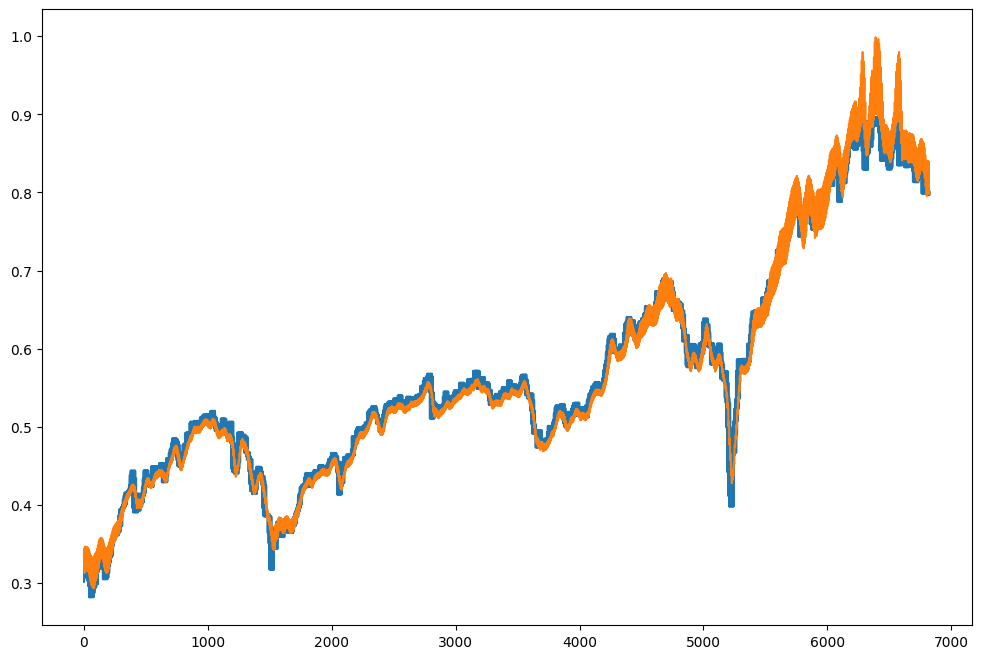

Reconstruction error threshold:  0.006106190137512403


In [448]:
# Get train MSE loss.
train_pred = model.predict(x_train)
train_mse_loss =  np.mean(np.power(x_train - train_pred, 2), axis=1)

# Checking how the first sequence is learnt
plt.plot(x_train.flatten())
plt.plot(train_pred.flatten())
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mse_loss)
print("Reconstruction error threshold: ", threshold)

In [449]:
# Create sequences from test values.
x_test = create_sequences(test_data.values,time_steps=TIME_STEPS)
print("Test input shape: ", x_test.shape)

# reconstruct the test data
test_predictions  = model.predict(x_test)

# Calculate reconstruction error for each time step
mse =  np.mean(np.power(x_test - test_predictions, 2), axis=1)


Test input shape:  (523, 7, 1)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Threshold =  0.01


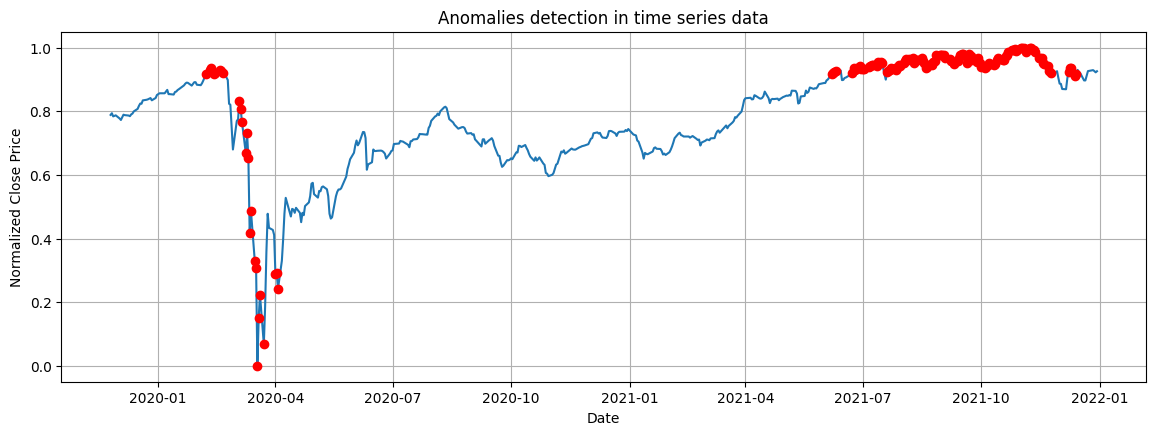

In [451]:
# Detect anomalies in test data
anomalies = detect_anomalies(mse, threshold = threshold)

# Detect all the samples which are anomalies and return a binary array
anomalies_binary = mse > threshold

# Plot test data with anomalies
"""Plot test data with detected anomalies."""
plt.figure(figsize=(14, 10))
# Create subplot grid with 2 rows and 1 column
plt.subplot(2, 1, 1)
plt.plot(test_data)
plt.plot(test_data['Adj_Close'].iloc[anomalies], 'ro')
plt.title('Anomalies detection in time series data')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.grid()

    # Create a new subplot for the anomaly plot
#plt.subplot(2, 1, 2)
# plt.plot(test_data['Adj_Close'].iloc[anomalies], 'ro')
# plt.title('Anomalies detection in time series data')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.grid() 
# plt.show()

<div class="alert alert-info">
  <strong>Keep in mind!</strong> 
Don't forget that since we are using time steps we see all the points in the time step window.
</div>



In [459]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_data) - TIME_STEPS + 1):
    if np.all(anomalies_binary[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

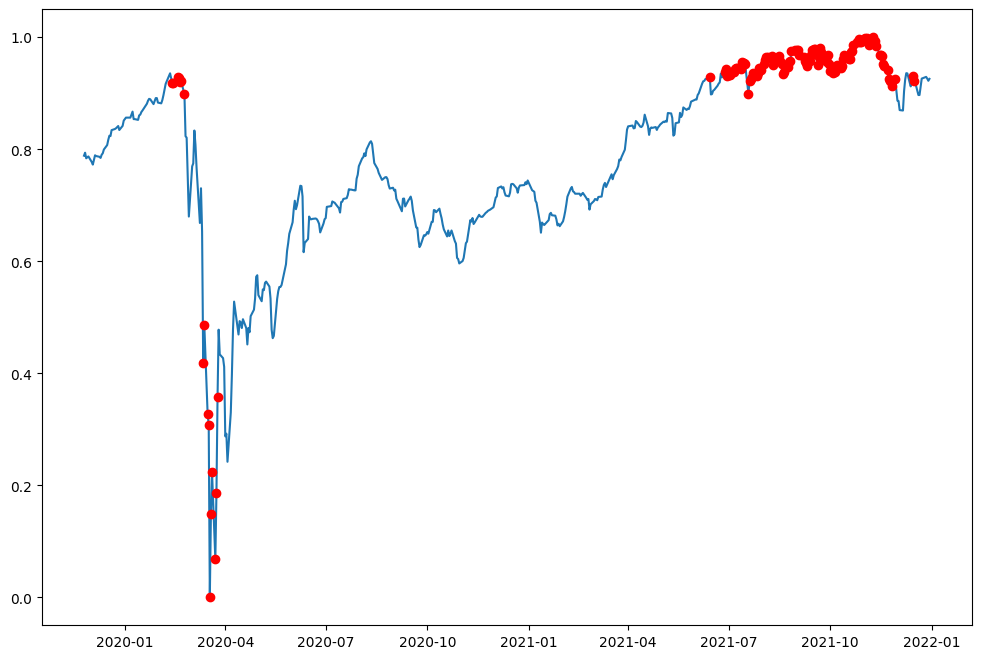

In [460]:
df_subset = test_data.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
plt.plot(test_data)
plt.plot(df_subset, 'ro')
plt.show()